# <center> Component Three David Webb 20104099 <center>

In [1]:
# import of necessary libraries for the data manipulation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('talk')
sns.set_palette("Set2")

print('libraries imported')

libraries imported


### Import of required data from Gov.uk files

Load previously used dataframe from Component 1 and 2

In [2]:
# import master dataframe from previous components
df = pd.read_csv('df.csv')

Add in additional regional data for each of the schools

In [3]:
# import the 'la_and_region_codes_meta' file
la_codes = pd.read_csv('la_and_region_codes_meta.csv')

# rename LEA column for consistency
la_codes.rename(columns={'LEA':'LA'}, inplace=True)

# merge authority data with master dataset
df = df.merge(la_codes[['LA', 'LA Name', 'REGION NAME']], how='left', on = ['LA'])

In [4]:
# define list of wider regions
wid_reg = ['North East', 'North West', 'Yorkshire', 'East Midlands', 'West Midlands', 'East of England',
          'London', 'South East', 'South West']

# generate new 'WIDER REGION' column
df['WIDER REGION'] = np.nan

# populate 'WIDER REGION' column based on the LA region variable
for x in wid_reg:
    df.loc[df['REGION NAME'].str.contains(x), 'WIDER REGION'] = x

Import and add in additional government data regarding rates of students remaining in education

In [5]:
df1 = pd.read_excel('england_ks4-pupdest.xlsx')

In [6]:
df1 = df1[['URN', 'LEA', 'EDUCATIONPER_DIS', 'EDUCATIONPER_NONDIS']]

df1.rename(columns={'LEA':'LA'}, inplace=True)

df = df.merge(df1, how='left', on=['URN', 'LA'])

Import and add in additional government data regarding rates of students gaining basic requirement grades in Maths and English

In [7]:
# import ks4 final data from gov website
df2 = pd.read_csv('england_ks4final.csv')

C:\Users\dave_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (53,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df2 = df2[['URN', 'LEA', 'PTFSM6CLA1ABASICS_94', 'PTNOTFSM6CLA1ABASICS_94']]

df2.rename(columns={'LEA':'LA'}, inplace=True)

df = df.merge(df2, how='left', on=['URN', 'LA'])

# remove supressed data points from dataframe
df = df.replace(['SUPP','NE','LOWCOV', 'SP'], np.nan)
df = df.dropna()

In [9]:
# convert basic requirement pass rate variables into useable data
# convert varaible types to strings
df[['PTFSM6CLA1ABASICS_94', 'PTNOTFSM6CLA1ABASICS_94']] = df[['PTFSM6CLA1ABASICS_94', 'PTNOTFSM6CLA1ABASICS_94']].astype('str')

# remove '%' sign from datapoints and convert varaibles back into float values
df['PTFSM6CLA1ABASICS_94'] = df['PTFSM6CLA1ABASICS_94'].map(lambda x: x.rstrip('%')).astype('float64')
df['PTNOTFSM6CLA1ABASICS_94'] = df['PTNOTFSM6CLA1ABASICS_94'].map(lambda x: x.rstrip('%')).astype('float64')

### Generation of figure 1 for the report

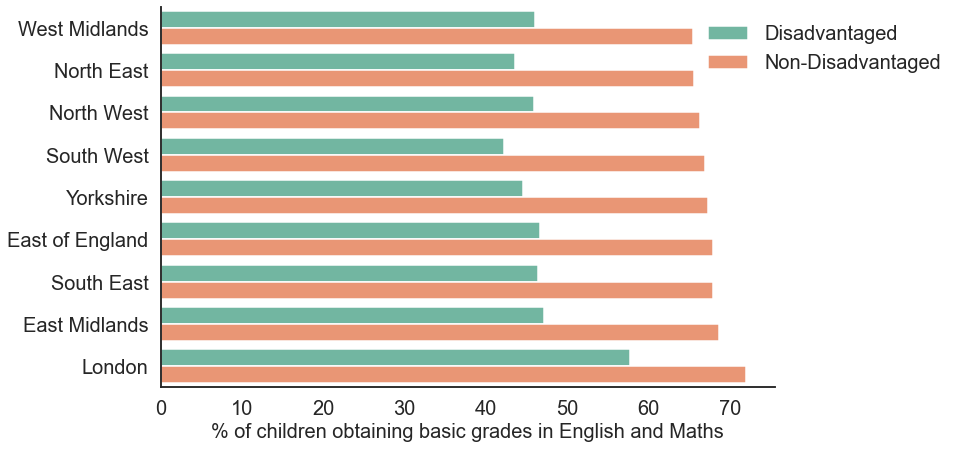

In [10]:
# create temparary dataframe which pools regional data on basic requirement pass rates
fig1_df = pd.DataFrame(df.groupby('WIDER REGION')[['PTFSM6CLA1ABASICS_94', 'PTNOTFSM6CLA1ABASICS_94']].mean())

# order data for the chart
fig1_df = fig1_df.sort_values('PTNOTFSM6CLA1ABASICS_94', ascending=True)

# stack data for easy use in a barchart
fig1_df = pd.DataFrame(fig1_df.stack().rename_axis(['WIDER REGION', 'DISS/NON-DISS']).rename('%').reset_index())

# rename data descriptors for use in the barchart key
fig1_df['DISS/NON-DISS'] = fig1_df['DISS/NON-DISS'].replace({'PTFSM6CLA1ABASICS_94':'Disadvantaged',
                                                            'PTNOTFSM6CLA1ABASICS_94':'Non-Disadvantaged'})

# generate barchart
plt.figure(figsize=(11,7))
sns.barplot('%', 'WIDER REGION', data=fig1_df, hue='DISS/NON-DISS', orient="h")
plt.ylabel('')
plt.xlabel('% of children obtaining basic grades in English and Maths', fontdict={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
lgd = plt.legend(title='', loc='upper right', frameon=False, fontsize=20, bbox_to_anchor=(1.3,1))
sns.despine()

# export figure for use in write up
plt.savefig('fig1.tiff', dpi=300, bbox_extra_artists=(lgd, ), bbox_inches='tight')

### Create new difference and relative difference variables for use in the data analysis

In [11]:
# create new variables within the dataset

# discard cases where there the number of students or the percentage is zero
df = df[df['EDUCATIONPER_NONDIS'] > 0]
df = df[df['PTNOTFSM6CLA1ABASICS_94'] > 0]

# create absolute gap columns
df['ATTAINMENT_GAP'] = df['PTNOTFSM6CLA1ABASICS_94'] - df['PTFSM6CLA1ABASICS_94']
df['EDUCATIONPER_GAP'] = (df['EDUCATIONPER_NONDIS'] - df['EDUCATIONPER_DIS']) * 100

# create relative gap columns
df['REL_ATTAINMENT_GAP'] = ((df['PTNOTFSM6CLA1ABASICS_94'] - df['PTFSM6CLA1ABASICS_94']) / df['PTNOTFSM6CLA1ABASICS_94']) * 100
df['REL_EDUCATIONPER_GAP'] = ((df['EDUCATIONPER_NONDIS'] - df['EDUCATIONPER_DIS']) / df['EDUCATIONPER_NONDIS']) * 100

# create relative difference columns
df['REL_ATTAINMENT_GAP_DIFF'] = df['REL_ATTAINMENT_GAP'] - df['REL_ATTAINMENT_GAP'].mean()
df['REL_EDUCATIONPER_GAP_DIFF'] = df['REL_EDUCATIONPER_GAP'] - df['REL_EDUCATIONPER_GAP'].mean()


### Generation of figure 2 for the report

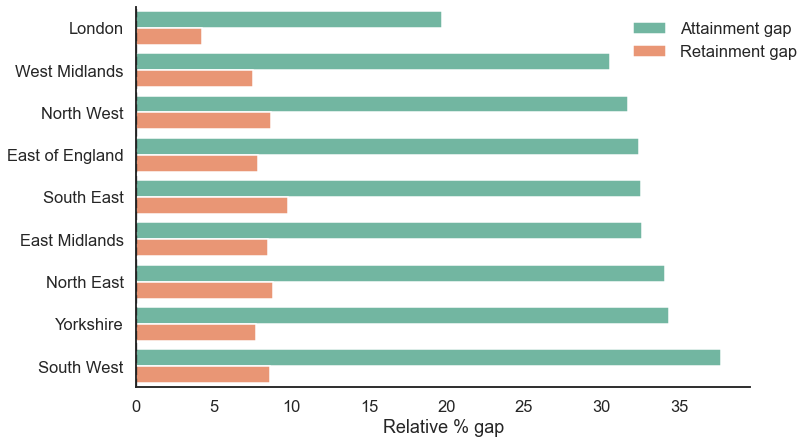

In [12]:
# create temparary dataframe which pools regional data on relative attainment and retainment gaps
fig2_df = pd.DataFrame(df.groupby('WIDER REGION')[['REL_ATTAINMENT_GAP', 'REL_EDUCATIONPER_GAP']].mean())

# order data for the chart
fig2_df = fig2_df.sort_values('REL_ATTAINMENT_GAP', ascending=True)

# stack data for easy use in a barchart
fig2_df = pd.DataFrame(fig2_df.stack().rename_axis(['WIDER REGION', 'GAP']).rename('%').reset_index())

# rename data descriptors for use in the barchart key
fig2_df['GAP'] = fig2_df['GAP'].replace({'REL_ATTAINMENT_GAP':'Attainment gap',
                                                            'REL_EDUCATIONPER_GAP':'Retainment gap'})

# generate barchart
plt.figure(figsize=(11, 7))
sns.barplot('%', 'WIDER REGION', data=fig2_df, hue='GAP', orient='h')
plt.xlabel('Relative % gap')
plt.ylabel('')
lgd = plt.legend(title='', loc='upper right', frameon=False, bbox_to_anchor=(1.1,1))
sns.despine()
plt.axvline(0, color='black', ls='--')

# export figure for use in write up
plt.savefig('fig2.tiff', dpi=300, bbox_extra_artists=(lgd, ), bbox_inches='tight')

### Generation of figure 3 for the report

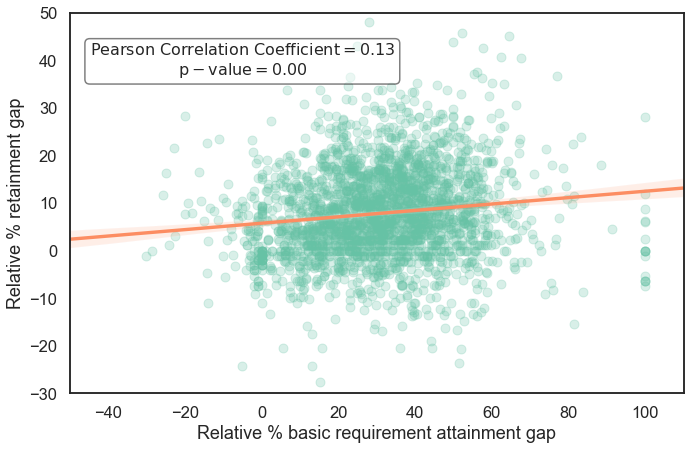

In [13]:
# generate correlation statistics for national level
from scipy import stats
r,p=stats.pearsonr(df['REL_ATTAINMENT_GAP'], df['REL_EDUCATIONPER_GAP'])

# generate national correlation plot
plt.figure(figsize=(11,7))
sns.regplot(df['REL_ATTAINMENT_GAP'], df['REL_EDUCATIONPER_GAP'], scatter_kws={'alpha':0.25}, line_kws={'color': sns.color_palette("Set2")[1]})
plt.ylim(-30, 50)
plt.xlim(-50, 110)
plt.ylabel('Relative % retainment gap')
plt.xlabel('Relative % basic requirement attainment gap')

# add in text box with correlation statistics
textstr = '\n'.join((
    r'$\mathrm{Pearson \ Correlation \ Coefficient}=%.2f$' % (r, ),
    r'$\mathrm{p-value}=%.2f$' % (p, )))
plt.annotate(textstr, (-5, 40), size=16,
            bbox=dict(boxstyle="round",facecolor='white',edgecolor='black', alpha=0.5), 
            horizontalalignment='center', verticalalignment='center')

# export figure for use in write up
plt.savefig('fig3.tiff', dpi=300)

### Generation of table 1 for the report

In [14]:
# create list of regions
regions = list(df['WIDER REGION'].unique())

# generate correlation data at a national level
r,p=stats.pearsonr(df['REL_ATTAINMENT_GAP'], df['REL_EDUCATIONPER_GAP'])

# create lists to store data
region = ['National']
pearson = [round(r, 3)]
pvalue = [round(p, 3)]

# loop through correlations for all regions and append to lists
for x in regions:
    df_temp = df[df['WIDER REGION'] == x]
    r,p=stats.pearsonr(df_temp['REL_ATTAINMENT_GAP'], df_temp['REL_EDUCATIONPER_GAP'])
    region.append(x)
    pearson.append(round(r, 3))
    pvalue.append(round(p, 3))

# put data into a dataframe    
table1 = pd.DataFrame({'Region':region, 'Pearson Correlation Coeff':pearson, 'p-value':pvalue})

# export dataframe for use in write-up
table1.to_csv(r'C:\Users\dave_\OneDrive\Documents\MMU Data Science Masters\Introduction to Data Science\Assignment\Write Up\table1.csv', index=False)
